# TP4, INF8225 2025, Projet


## Imports

In [1]:
from IPython.display import clear_output

%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
%pip install numpy
%pip install swig
%pip install box2d
%pip install pygame
%pip install gymnasium
%pip install "gymnasium[box2d]"
%pip install matplotlib
%pip install wandb

clear_output()

In [22]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
import torch
import torch.nn as nn
from torch.distributions import Normal
import torchvision.transforms as T
import pygame
import time
import os
import wandb
from IPython.display import clear_output

### Initialisation

In [23]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.version.cuda)

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))

True
12.1
NVIDIA GeForce GTX 1050


## Data Declaration

In [24]:
# Inspired by : https://github.com/pangyyen/carRacing-DeepRL/blob/main/ppo/ppo.ipynb

env = gym.make("CarRacing-v3", render_mode="rgb_array", domain_randomize=False)
print("Observation space: ", env.observation_space) # (low, high, shape, dtype)
print("Action space: ", env.action_space)

SEED = 42

go_up = np.array([0.0, 1.0, 0.0])
no_action = np.array([0.0, 0.0, 0.0])

observation, info = env.reset(seed=SEED)

def show_animation():
	show_animation_frames(env.render())

def show_animation_frames(frames):
	fig = plt.figure(figsize=(7, 5))
	plt.axis('off')
	im = plt.imshow(frames[0])

	def animate(i):
		im.set_data(frames[i])
		return im,

	anim = animation.FuncAnimation(fig, animate, frames=len(frames), repeat=False)
	plt.close(fig)
	display(HTML(anim.to_jshtml()))

def show_current_frame(env, data):
	frame = env.render()
	fig, _ = plt.subplots()
	r = fig.canvas.get_renderer()
	plt.imshow(frame)
	plt.axis('off')
	texts = []
	size_used = 0
	for i, key in enumerate(data):
		text = plt.text(0, 0, f'{key}: {data[key]}', fontsize=12, color='black', backgroundcolor='white', ha="center")
		size_used += text.get_window_extent(renderer=r).width
		texts.append(text)
	split = (700 - size_used) / (len(data) + 1)
	next_position = split
	for t in texts:
		t.set_position((next_position, 0))
		next_position = next_position + t.get_window_extent(renderer=r).width + split
	clear_output(wait=True)
	plt.show()

def skip_zooming(env):
	for i in range(50):
		observation, _, terminated, truncated, info = env.step(no_action)

		if terminated or truncated:
			observation, info = env.reset()
			break
	return observation, info

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Box([-1.  0.  0.], 1.0, (3,), float32)


## Implementation

### DQN

### PPO

In [ ]:
# TODO - Remove this cell when finish implementation

observation, info = env.reset(seed=SEED)
for i in range(100):
	#action = env.action_space.sample()
	observation, reward, terminated, truncated, info = env.step(go_up)
	#print(f"Step: {i}, Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}, Info: {info}")

	if terminated or truncated:
		observation, info = env.reset()
env.close()

#show_animation()

#### Model

In [ ]:
transform = T.Compose([
	T.ToPILImage(),
	T.Grayscale(num_output_channels=1),
	T.Resize((84, 84)),
	T.ToTensor(),
	T.Normalize((0.5,), (0.5,))
])

class Actor(nn.Module):
	def __init__(self, action_dim, actor_std, hidden_sizes=[1024, 512], is_log_std = False):
		super().__init__()

		self.is_log_std = is_log_std
		self.actor_std = actor_std
			
		self.cnn = nn.Sequential(
			nn.Conv2d(1, 32, 8, stride=4), nn.LeakyReLU(),
			nn.Conv2d(32, 64, 4, stride=2), nn.LeakyReLU(),
			nn.Conv2d(64, 64, 3, stride=1), nn.LeakyReLU(),
			nn.Flatten()
		)

		with torch.no_grad():
			dummy = torch.zeros(1, 1, 84, 84)
			n_flatten = self.cnn(dummy).shape[1]

		layers = []
		in_features = n_flatten
		for hidden in hidden_sizes:
			layers.append(nn.Linear(in_features, hidden))
			layers.append(nn.LeakyReLU())
			in_features = hidden
		layers.append(nn.Linear(in_features, action_dim))
		layers.append(nn.Tanh())
		self.fc = nn.Sequential(*layers)

		if is_log_std:
			self.std = nn.Parameter(torch.full((action_dim,), torch.log(torch.tensor(self.actor_std))).to(device))
		else:
			self.std = torch.full((action_dim,), self.actor_std).to(device)
		
	def forward(self, x):
		x = self.cnn(x)
		mean = self.fc(x)
		if self.is_log_std:
			std = self.std.exp()
			return mean, std
		else:
			return mean, self.std
	

class Critic(nn.Module):
	def __init__(self, hidden_sizes=[1024, 512]):
		super().__init__()

		self.cnn = nn.Sequential(
			nn.Conv2d(1, 32, 8, stride=4), nn.LeakyReLU(),
			nn.Conv2d(32, 64, 4, stride=2), nn.LeakyReLU(),
			nn.Conv2d(64, 64, 3, stride=1), nn.LeakyReLU(),
			nn.Flatten()
		)

		with torch.no_grad():
			dummy = torch.zeros(1, 1, 84, 84)
			n_flatten = self.cnn(dummy).shape[1]

		layers = []
		in_features = n_flatten
		for hidden in hidden_sizes:
			layers.append(nn.Linear(in_features, hidden))
			layers.append(nn.LeakyReLU())
			in_features = hidden
		layers.append(nn.Linear(in_features, 1))
		self.fc = nn.Sequential(*layers)

	def forward(self, x):
		x = self.cnn(x)
		return self.fc(x)

class PPO:
	def __init__(self, env, save_path="ppo.pth", lr_actor=3e-4, lr_critic=3e-4, actor_std=0.4, gamma=0.99, eps_clip=0.2, K_epochs=4, is_log_std = False, actor_embeddings=[1024, 512], critic_embeddings=[1024, 512]):
		self.env = env
		self.action_space_low = torch.tensor(self.env.action_space.low).to(device)
		self.action_space_high = torch.tensor(self.env.action_space.high).to(device)
		self.save_path = save_path
		self.action_dim = env.action_space.shape[0]
		self.actor = Actor(self.action_dim, actor_std, actor_embeddings, is_log_std).to(device)
		self.critic = Critic(critic_embeddings).to(device)
		self.optimizer = torch.optim.Adam([
                        {'params': self.actor.parameters(), 'lr': lr_actor},
                        {'params': self.critic.parameters(), 'lr': lr_critic}
                    ])
		self.gamma = gamma
		self.eps_clip = eps_clip
		self.K_epochs = K_epochs
	
	def save(self):
		torch.save({ 'actor_state_dict': self.actor.state_dict(), 'critic_state_dict': self.critic.state_dict() }, self.save_path)

	def load(self):
		if os.path.isfile(self.save_path):
			checkpoint = torch.load(self.save_path, map_location=device)
			self.actor.load_state_dict(checkpoint['actor_state_dict'])
			self.critic.load_state_dict(checkpoint['critic_state_dict'])

	def select_action(self, state):
		state = transform(state).unsqueeze(0).to(device)
		mean, std = self.actor(state)
		dist = Normal(mean, std)
		action = dist.sample()
		log_prob = dist.log_prob(action).sum(-1)
		formated_action = torch.tensor((action[0] + 1) / 2 * (self.action_space_high - self.action_space_low) + self.action_space_low).to(device)
		formated_action = torch.clamp(formated_action, self.action_space_low, self.action_space_high)
		return formated_action.cpu().numpy(), log_prob.item()

	def evaluate(self, states, actions):
		mean, std = self.actor(states)
		dist = Normal(mean, std)
		log_probs = dist.log_prob(actions).sum(-1)
		entropy = dist.entropy().sum(-1)
		values = self.critic(states).squeeze(-1)
		return log_probs, values, entropy

	def compute_returns(self, rewards, dones, next_value):
		returns = []
		R = next_value
		for step in reversed(range(len(rewards))):
			R = rewards[step] + self.gamma * R * (1 - dones[step])
			returns.insert(0, R)
		return returns

	def update(self, memory):
		states = torch.stack(memory['states']).to(device)
		actions = torch.stack(memory['actions']).to(device)
		old_log_probs = torch.tensor(memory['log_probs']).to(device)
		returns = torch.tensor(memory['returns']).to(device)

		for _ in range(self.K_epochs):
			log_probs, values, entropy = self.evaluate(states, actions)
			advantages = returns - values.detach()

			ratio = (log_probs - old_log_probs).exp()
			surr1 = ratio * advantages
			surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
			actor_loss = -torch.min(surr1, surr2).mean()
			critic_loss = nn.MSELoss()(values, returns)
			loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy.mean()
			print(f"Loss: {loss}")

			self.optimizer.zero_grad()
			loss.backward()
			self.optimizer.step()

		self.save()
		return loss

In [ ]:
test = torch.tensor([ 0.1010,  0.6041, -0.2350])

In [ ]:
config = {
	"seed": SEED,
	"max_episodes": 300000,
	"max_timesteps": 10000,
	"is_log_std": False,
	"lr_actor": 3e-4,
	"actor_std": 0.5,
	"actor_embeddings": [1024, 512],
	"lr_critic": 3e-4,
	"critic_embeddings": [1024, 512],
	"gamma": 0.99,
	"eps_clip": 0.2,
	"k_epochs": 4, 
}

ppo = PPO(env, lr_actor=config["lr_actor"], lr_critic=config["lr_critic"], actor_std=config["actor_std"], gamma=config["gamma"], eps_clip=config["eps_clip"], K_epochs=config["k_epochs"], is_log_std=config["is_log_std"], actor_embeddings=config["actor_embeddings"], critic_embeddings=config["critic_embeddings"])

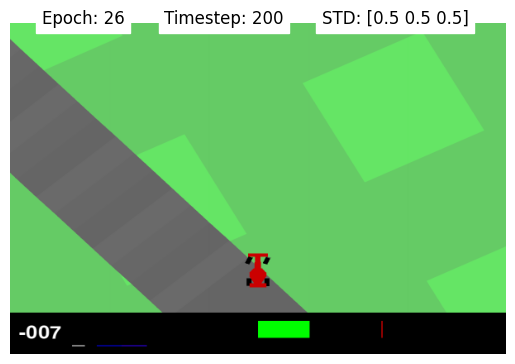

Loss: 1.5543206930160522
Loss: 1.2230104207992554
Loss: 0.8511720299720764
Loss: 0.8241217732429504


Traceback (most recent call last):
  File "C:\Users\Alexandre\AppData\Local\Temp\ipykernel_15200\3807754839.py", line 54, in <module>
    loss = ppo.update(memory)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\Alexandre\AppData\Local\Temp\ipykernel_15200\2296927272.py", line 154, in update
    self.save()
  File "C:\Users\Alexandre\AppData\Local\Temp\ipykernel_15200\2296927272.py", line 98, in save
    torch.save({ 'actor_state_dict': self.actor.state_dict(), 'critic_state_dict': self.critic.state_dict() }, self.save_path)
  File "d:\Repo_Git\INF8225\.venv\Lib\site-packages\torch\serialization.py", line 849, in save
    with _open_zipfile_writer(f) as opened_zipfile:
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Repo_Git\INF8225\.venv\Lib\site-packages\torch\serialization.py", line 716, in _open_zipfile_writer
    return container(name_or_buffer)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Repo_Git\INF8225\.venv\Lib\site-packages\torch\serialization.py", line 687, in __init__
    su

braking,▅▄▃▅▄█▂▁▁▂▂▁▂▂▁▄▁▄▂▁▁▂▁▁▄▁▁▁▁▂▁▁▄▂▃▁▁▁▄▃
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
gas,█▄▄▄▃▁▁▁▄▁▁▂▂▁▁▂▂▁▂▁▄▁▁▁▁▁▁▁▁▁▁▃▃▁▂▁▂▅▁▃
loss,█▇▆▆▄▂▂▂▂▂▂▂▁▁▁▁▂▂▂▁▂▁▃▁▂▁
reward,█▄▁▅▆▄▃▅▄▄▅▅▂▄▄▅▅▄▆▅▅▃▄▅▆▄
steering,▅▃▄▁▃████▂██▆▇▅▇▇██████▆█▆██▆█▆███▆▅█▅▇█
timestep,▃▁▃▄▅██▄▃▃▂▂▂▃▁▄▄▄▁▂▂▃▂▃▃▃▂▃▁▂▃▁▂▃▂▃▄▂▁▃
total_reward,█▇▇▇▇▅▇▅▅▅▁▇▆▄▇▇█▇▆▆█▅▆▆▆▃▇▆█▇▆▆▇▆▆▆▇▇█▅
braking,0.06499
epoch,26
gas,0


RuntimeError: File ppo.pth cannot be opened.

In [ ]:
with wandb.init(
        config=config,
        project='INF8225 - TP4',
        group='PPO',
        save_code=True,
    ):
	max_episodes = config["max_episodes"]
	max_timesteps = config["max_timesteps"]

	ppo.actor.train()
	ppo.critic.train()
	for ep in range(max_episodes):
		start = time.time()
		state, _ = env.reset(seed=config["seed"])
		state, _ = skip_zooming(env)
		
		memory = {'states': [], 'actions': [], 'log_probs': [], 'rewards': [], 'dones': []}
		total_reward = 0
		t = 0

		for t in range(max_timesteps):
			state_t = transform(state).to(device)
			memory['states'].append(state_t)

			action, log_prob = ppo.select_action(state)
			next_state, reward, done, trunc, _ = env.step(action)

			memory['actions'].append(torch.FloatTensor(action).to(device))
			memory['log_probs'].append(log_prob)
			memory['rewards'].append(reward)
			memory['dones'].append(done)

			state = next_state
			total_reward += reward

			wandb.log({"timestep": t, "steering": action.tolist()[0], "gas": action.tolist()[1], "braking": action.tolist()[2], "total_reward": total_reward })

			if t % 50 == 0:
				show_current_frame(env, {"Epoch": ep, "Timestep": t, "STD": ppo.actor.std.detach().cpu().numpy()})

			if (len(memory['rewards']) > 100 and np.max(np.array(memory['rewards'][-100:])) < 0):
				total_reward -= 20
				break

			if done or trunc:
				break

		with torch.no_grad():
			next_state_t = transform(state).unsqueeze(0).to(device)
			next_value = ppo.critic(next_state_t).item()
		memory['returns'] = ppo.compute_returns(memory['rewards'], memory['dones'], next_value)

		loss = ppo.update(memory)
		image = wandb.Image(env.render(), caption=f"Epoch {ep+1}")
		print(f"Episode {ep+1} - Reward: {total_reward:.1f} - Time: {time.time() - start}")
		wandb.log({"epoch": ep+1, "reward": total_reward, "loss": loss, "image": image })

	env.close()

In [ ]:
action.tolist()[2]

-0.011987268924713135

In [ ]:
state, _ = env.reset(seed=SEED)
total_reward = 0

ppo.actor.eval()
ppo.critic.eval()
#while True:
for i in range(200):
	state_tensor = transform(state).unsqueeze(0).to(device)

	with torch.no_grad():
		mean, _ = ppo.actor(state_tensor)
		action = mean.squeeze(0).cpu().numpy()
	
	action = np.clip(action, -1, 1)
	state, reward, done, trunc, _ = env.step(action)
	total_reward += reward

	if done or trunc:
		break

env.close()
show_animation()
print(f"Test reward: {total_reward:.2f}")

Test reward: 8.27


### Human Testing

In [ ]:
env = gym.make("CarRacing-v3", render_mode="human")
obs = env.reset()[0]

pygame.init()
win = pygame.display.set_mode((1000, 1000))
pygame.display.set_caption("Keyboard Controller")

clock = pygame.time.Clock()

running = False # TODO Set to TRUE if you want to play manually
action = np.array([0.0, 0.0, 0.0])  # [steer, gas, brake]

def process_keys():
    keys = pygame.key.get_pressed()
    steer = 0.0
    gas = 0.0
    brake = 0.0

    if keys[pygame.K_LEFT]:
        steer = -1.0
    elif keys[pygame.K_RIGHT]:
        steer = 1.0

    if keys[pygame.K_UP]:
        gas = 1.0
    if keys[pygame.K_DOWN]:
        brake = 1.0

    return np.array([steer, gas, brake])

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    action = process_keys()
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    if done:
        obs = env.reset()[0]

    clock.tick(60)  # Limit to 60 FPS

env.close()
pygame.quit()